<a href="https://colab.research.google.com/github/doanhieung/colab_notebooks/blob/main/PSIG_based_Malware_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Note: This notebook was initially run on an Nvidia Geforce RTX 4070 machine for optimal performance.
# If you run it on Colab, uncomment and execute the following code in this cell to install required dependencies.

# import os
# import torch

# os.environ["TORCH"] = torch.__version__
# print(torch.__version__)

# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# !mkdir model

In [ ]:
import torch
import networkx as nx
from glob import glob
from tqdm.notebook import tqdm
from torch_geometric.utils import from_networkx
from torch_geometric.transforms import LocalDegreeProfile
from sklearn.model_selection import train_test_split

transform = LocalDegreeProfile()


def read_graph(path):
    with open(path, "r") as f:
        lines = f.readlines()
    G = nx.DiGraph()
    nodes = lines[1].split(" ")
    G.add_nodes_from(nodes)
    for line in lines[2:]:
        edge = line.split(" ")
        if len(edge) == 2:
            G.add_edge(edge[0], edge[1])
    return G


paths = glob("data/PSI-Graph/*/*.txt")
data_list = []
for path in tqdm(paths):
    G = read_graph(path)
    data = from_networkx(G)
    if "malware" in path:
        data.y = torch.tensor([1], dtype=torch.int64)
    else:
        data.y = torch.tensor([0], dtype=torch.int64)
    data = transform(data)
    data_list.append(data)


nodes, edges = [], []
labels = []
for data in data_list:
    nodes.append(data.num_nodes)
    edges.append(data.num_edges)
    labels.append(data.y.item())


train_data, test_data, train_labels, _ = train_test_split(
    data_list, labels, test_size=0.2, stratify=labels, random_state=42
)
train_data, val_data, _, _ = train_test_split(
    train_data, train_labels, test_size=0.125, stratify=train_labels, random_state=42
)
print(len(train_data), len(val_data), len(test_data))

  0%|          | 0/9670 [00:00<?, ?it/s]

6769 967 1934


In [ ]:
import pandas as pd

pd.DataFrame({"nodes": nodes, "edges": edges}).describe()

,nodes,edges
count,9670.000000,9670.000000
mean,232.028025,314.962978
std,566.876416,1087.949983
min,3.000000,1.000000
25%,21.000000,15.000000
50%,98.000000,101.000000
75%,267.000000,313.000000
max,17960.000000,25565.000000


### Explore Dataset

In [ ]:
data = train_data[0]

# Gather some statistics about the first graph.
print(data)
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Has isolated nodes: {data.has_isolated_nodes()}")
print(f"Has self-loops: {data.has_self_loops()}")
print(f"Is undirected: {data.is_undirected()}")

Data(edge_index=[2, 237], num_nodes=208, y=[1], x=[208, 5])
Number of nodes: 208
Number of edges: 237
Has isolated nodes: True
Has self-loops: False
Is undirected: False


In [ ]:
from torch_geometric.loader import DataLoader

BATCH_SIZE = 128

# Create loaders for train, validation, and test datasets
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
import torch
import time
import torch.nn.functional as F
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt


if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")


def num_graphs(data):
    """
    Returns the number of graphs in a batch of data.
    """
    if hasattr(data, "num_graphs"):
        return data.num_graphs
    else:
        return data.x.size(0)


def train(model, optimizer, loader):
    """
    Train the model for one epoch.

    Args:
        model: The model to train.
        optimizer: The optimizer for updating model parameters.
        loader: DataLoader object providing batches of data for training.

    Returns:
        Average training loss.
    """
    model.train()

    total_loss = 0
    for data in loader:
        optimizer.zero_grad()
        data = data.to(device)
        out = model(data)
        loss = F.nll_loss(out, data.y.view(-1))
        loss.backward()
        total_loss += loss.item() * num_graphs(data)
        optimizer.step()
    return total_loss / len(loader.dataset)


def eval_acc(model, loader):
    """
    Evaluates the model to calculate accuracy over a dataset.

    Args:
        model: The model to evaluate.
        loader: DataLoader object providing batches of data.

    Returns:
        Accuracy over the dataset.
    """
    model.eval()

    correct = 0
    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            pred = model(data).max(1)[1]
        correct += pred.eq(data.y.view(-1)).sum().item()
    return correct / len(loader.dataset)


def eval_loss(model, loader):
    """
    Evaluates the model to calculate the average loss over a dataset.

    Args:
        model: The model to evaluate.
        loader: DataLoader object providing batches of data.

    Returns:
        Average loss over the dataset.
    """
    model.eval()

    loss = 0
    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            out = model(data)
        loss += F.nll_loss(out, data.y.view(-1), reduction="sum").item()
    return loss / len(loader.dataset)


def train_epochs(start, stop, model, optimizer, history):
    """
    Train the model over a specified range of epochs, and evaluate the model on validation data after each epoch.

    Args:
        start_epoch: Starting epoch number (inclusive).
        end_epoch: Ending epoch number (inclusive).
        model: The model to train.
        optimizer: Optimizer for updating the model parameters.
        history: A dictionary to store training loss, validation loss, and validation accuracy.

    Returns:
        Training time.
    """
    t0 = time.perf_counter()
    prev_eval_info = ""
    for epoch in range(start, stop + 1):
        history["train_loss"].append(train(model, optimizer, train_loader))
        history["val_loss"].append(eval_loss(model, val_loader))
        history["val_acc"].append(eval_acc(model, val_loader))

        if history["val_loss"][-1] == min(history["val_loss"]):
            torch.save(model.state_dict(), f"model/PSIG/{model}.pth")

        eval_info = {
            "epoch": epoch,
            "train_loss": history["train_loss"][-1],
            "val_loss": history["val_loss"][-1],
            "val_acc": history["val_acc"][-1],
        }
        print(str(eval_info).ljust(len(prev_eval_info)), end="\r")
        prev_eval_info = str(eval_info)
    return int(time.perf_counter() - t0)


def draw_training_history(history):
    """
    Plots the training history, including loss and accuracy for both training and validation sets.

    Args:
        history: A dictionary containing training/validation loss and accuracy per epoch.
    """
    # Create a figure and axis
    fig, ax1 = plt.subplots(figsize=(8, 5))

    # Plot training and validation loss
    ax1.plot(history["train_loss"], label="Training Loss", color="blue")
    ax1.plot(history["val_loss"], label="Validation Loss", color="orange")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss", color="black")
    ax1.tick_params(axis="y", labelcolor="black")
    ax1.legend(loc="upper left")

    # Create a second y-axis for accuracy
    ax2 = ax1.twinx()
    ax2.plot(history["val_acc"], label="Validation Accuracy", color="green", ls=":")
    ax2.set_ylabel("Accuracy", color="black")
    ax2.tick_params(axis="y", labelcolor="black")

    # Add title and show the plot
    plt.title("Training History")
    fig.tight_layout()  # Adjust layout to prevent overlap
    plt.show()


def test(model, loader):
    """
    Test the model on the test dataset and print the classification report.

    Args:
        model: The trained GCN model to evaluate.
        loader: DataLoader object providing batches of data from the test set.

    Returns:
        A classification report showing precision, recall, and F1-score for each class.
    """
    model.eval()
    y_true, y_pred = [], []
    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            pred = model(data).max(1)[1]
        y_true.extend(data.y.view(-1).tolist())
        y_pred.extend(pred.tolist())
    print(classification_report(y_pred, y_true, digits=4))

### Graph Convolutional Network

#### Train

In [ ]:
from torch.nn import Linear

from torch_geometric.nn import GCNConv, global_max_pool, JumpingKnowledge


class GCNWithJK(torch.nn.Module):
    """
    Graph Convolutional Network with Jumping Knowledge.

    Args:
        dataset: The dataset object, used to define input and output sizes.
        num_layers: Number of graph convolutional layers.
        hidden: Number of hidden units in each layer.
        mode: The aggregation scheme to use (default to concatenation - "cat").

    Methods:
        reset_parameters: Resets the parameters of the model.
        forward: Defines the forward pass of the model.
    """

    def __init__(self, num_features, num_classes, num_layers, hidden, mode="cat"):
        super().__init__()
        self.conv1 = GCNConv(num_features, hidden)
        self.convs = torch.nn.ModuleList()
        for i in range(num_layers - 1):
            self.convs.append(GCNConv(hidden, hidden))
        self.jump = JumpingKnowledge(mode)
        if mode == "cat":
            self.lin = Linear(num_layers * hidden, num_classes)
        else:
            self.lin = Linear(hidden, num_classes)

    def reset_parameters(self):
        self.conv1.reset_parameters()
        for conv in self.convs:
            conv.reset_parameters()
        self.jump.reset_parameters()
        self.lin.reset_parameters()

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        xs = [x]
        for conv in self.convs:
            x = F.relu(conv(x, edge_index))
            xs += [x]
        x = self.jump(xs)
        x = global_max_pool(x, batch)
        x = self.lin(x)
        return F.log_softmax(x, dim=-1)

    def __repr__(self):
        return self.__class__.__name__

In [ ]:
from torch.optim import Adam

# Create model
model = GCNWithJK(num_features=5, num_classes=2, num_layers=6, hidden=128)
model.to(device).reset_parameters()

optimizer = Adam(model.parameters())

if torch.cuda.is_available():
    torch.cuda.synchronize()

# Prepare history tracking
history = {"train_loss": [], "val_loss": [], "val_acc": []}

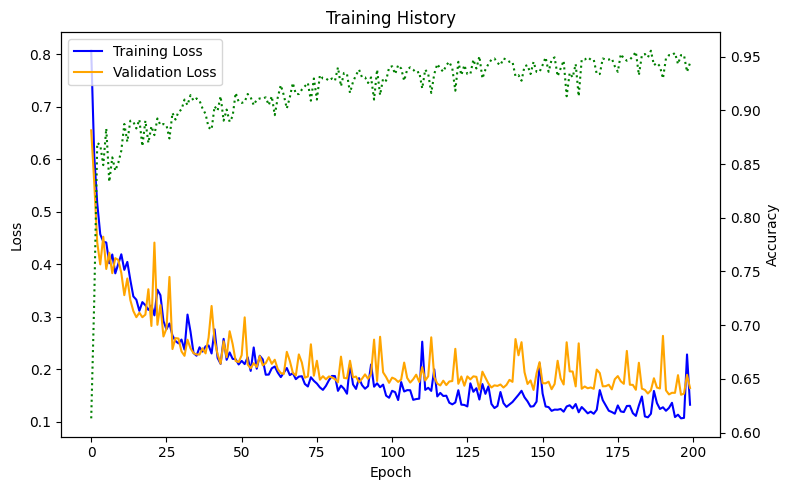

Best val loss: 0.1516149283195109
Training time: 162 (s)


In [ ]:
# Train the model for epochs
training_time = train_epochs(1, 200, model, optimizer, history)

draw_training_history(history)
print("Best val loss:", min(history["val_loss"]))
print("Training time:", training_time, "(s)")

#### Test

In [ ]:
# Load and test the best model
print(model)
model.load_state_dict(torch.load(f"model/PSIG/{model}.pth", weights_only=True))
test(model, test_loader)

GCNWithJK
              precision    recall  f1-score   support

           0     0.9317    0.9444    0.9380       737
           1     0.9655    0.9574    0.9614      1197

    accuracy                         0.9524      1934
   macro avg     0.9486    0.9509    0.9497      1934
weighted avg     0.9526    0.9524    0.9525      1934



### GraphSAGE

#### Train

In [ ]:
from torch_geometric.nn import JumpingKnowledge, SAGEConv


class GraphSAGEWithJK(torch.nn.Module):

    def __init__(self, num_features, num_classes, num_layers, hidden, mode="cat"):
        super().__init__()
        self.conv1 = SAGEConv(num_features, hidden)
        self.convs = torch.nn.ModuleList()
        for i in range(num_layers - 1):
            self.convs.append(SAGEConv(hidden, hidden))
        self.jump = JumpingKnowledge(mode)
        if mode == "cat":
            self.lin = Linear(num_layers * hidden, num_classes)
        else:
            self.lin = Linear(hidden, num_classes)

    def reset_parameters(self):
        self.conv1.reset_parameters()
        for conv in self.convs:
            conv.reset_parameters()
        self.jump.reset_parameters()
        self.lin.reset_parameters()

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        xs = [x]
        for conv in self.convs:
            x = F.relu(conv(x, edge_index))
            xs += [x]
        x = self.jump(xs)
        x = global_max_pool(x, batch)
        x = self.lin(x)
        return F.log_softmax(x, dim=-1)

    def __repr__(self):
        return self.__class__.__name__

In [ ]:
from torch.optim import Adam

# Create model
model = GraphSAGEWithJK(num_features=5, num_classes=2, num_layers=6, hidden=128)
model.to(device).reset_parameters()

optimizer = Adam(model.parameters())

if torch.cuda.is_available():
    torch.cuda.synchronize()

# Prepare history tracking
history = {"train_loss": [], "val_loss": [], "val_acc": []}

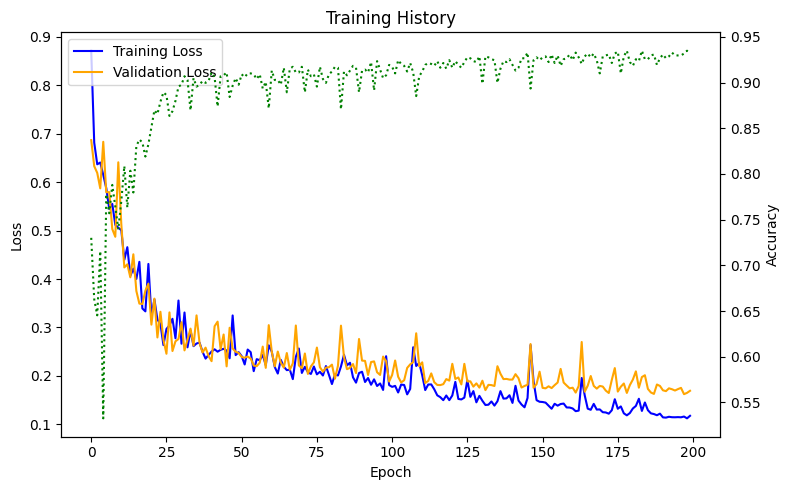

Best val loss: 0.16232421208315576
Training time: 137 (s)


In [ ]:
# Train the model for epochs
training_time = train_epochs(1, 200, model, optimizer, history)

draw_training_history(history)
print("Best val loss:", min(history["val_loss"]))
print("Training time:", training_time, "(s)")

#### Test

In [ ]:
# Load and test the best model
print(model)
model.load_state_dict(torch.load(f"model/PSIG/{model}.pth", weights_only=True))
test(model, test_loader)

GraphSAGEWithJK
              precision    recall  f1-score   support

           0     0.8755    0.9703    0.9205       674
           1     0.9832    0.9262    0.9538      1260

    accuracy                         0.9416      1934
   macro avg     0.9293    0.9483    0.9371      1934
weighted avg     0.9456    0.9416    0.9422      1934



### Graph Isomorphism Network

#### Train

In [ ]:
import torch.nn.functional as F
from torch.nn import BatchNorm1d as BN
from torch.nn import Linear, ReLU, Sequential

from torch_geometric.nn import GINConv, JumpingKnowledge, global_max_pool


class GINWithJK(torch.nn.Module):

    def __init__(self, num_features, num_classes, num_layers, hidden, mode="cat"):
        super().__init__()
        self.conv1 = GINConv(
            Sequential(
                Linear(num_features, hidden),
                ReLU(),
                BN(hidden),
                Linear(hidden, hidden),
                ReLU(),
                BN(hidden),
            ),
            train_eps=True,
        )
        self.convs = torch.nn.ModuleList()
        for i in range(num_layers - 1):
            self.convs.append(
                GINConv(
                    Sequential(
                        Linear(hidden, hidden),
                        ReLU(),
                        BN(hidden),
                        Linear(hidden, hidden),
                        ReLU(),
                        BN(hidden),
                    ),
                    train_eps=True,
                )
            )
        self.jump = JumpingKnowledge(mode)
        if mode == "cat":
            self.lin = Linear(num_layers * hidden, num_classes)
        else:
            self.lin = Linear(hidden, num_classes)

    def reset_parameters(self):
        self.conv1.reset_parameters()
        for conv in self.convs:
            conv.reset_parameters()
        self.jump.reset_parameters()
        self.lin.reset_parameters()

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        xs = [x]
        for conv in self.convs:
            x = conv(x, edge_index)
            xs += [x]
        x = self.jump(xs)
        x = global_max_pool(x, batch)
        x = self.lin(x)
        return F.log_softmax(x, dim=-1)

    def __repr__(self):
        return self.__class__.__name__

In [ ]:
from torch.optim import Adam

# Create model
model = GINWithJK(num_features=5, num_classes=2, num_layers=6, hidden=128)
model.to(device).reset_parameters()

optimizer = Adam(model.parameters())

if torch.cuda.is_available():
    torch.cuda.synchronize()

# Prepare history tracking
history = {"train_loss": [], "val_loss": [], "val_acc": []}

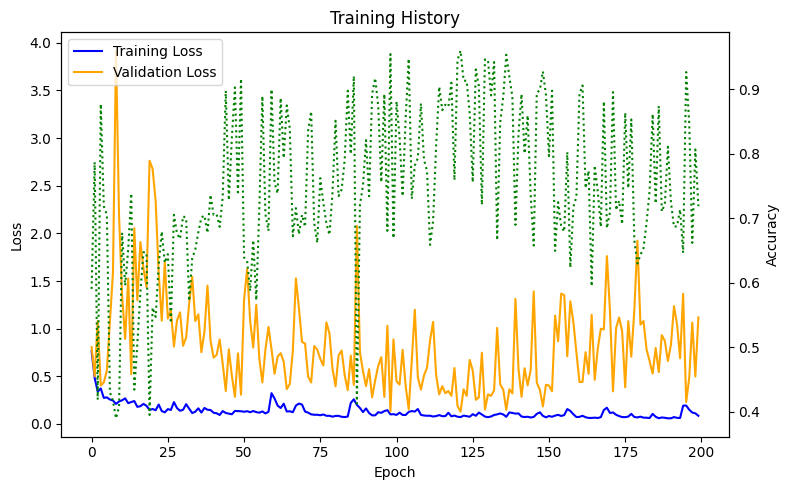

Best val loss: 0.12821122063969137
Training time: 186 (s)


In [ ]:
# Train the model for epochs
training_time = train_epochs(1, 200, model, optimizer, history)

draw_training_history(history)
print("Best val loss:", min(history["val_loss"]))
print("Training time:", training_time, "(s)")

#### Test

In [ ]:
# Load and test the best model
print(model)
model.load_state_dict(torch.load(f"model/PSIG/{model}.pth", weights_only=True))
test(model, test_loader)

GINWithJK
              precision    recall  f1-score   support

           0     0.9545    0.9332    0.9437       764
           1     0.9570    0.9709    0.9639      1170

    accuracy                         0.9560      1934
   macro avg     0.9558    0.9521    0.9538      1934
weighted avg     0.9560    0.9560    0.9560      1934

